In [4]:
%matplotlib notebook
# %matplotlib inline
from sklearn import datasets, model_selection
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.legend_handler import HandlerLine2D
# from utils import *

In [32]:
def scatter_dataset(ax,X,y,s=10,**params):
    for i in range(int(np.max(y))+1):
        ax.scatter(X[y==i][:,0],X[y==i][:,1],s=s,**params)
        ax.scatter(X[y==i][:,0],X[y==i][:,1],s=s,**params)
    
    
def plot_contours(ax, predict, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = predict(np.c_[xx.ravel(), yy.ravel()])
#     Z[Z<0]=0
#     Z[Z>0]=1
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, int(np.max(Z)),**params)
    return out

def make_meshgrid(x_min,x_max,y_min,y_max, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy    

def spiral(n):
    def pol2cart(rho, phi):
        x = rho * np.cos(phi)
        y = rho * np.sin(phi)
        return(x, y)
    Y=[]
    X = []
    for i in range(4):
        theta = np.random.uniform(low=4.5,high=6.5,size=n)
        rho = 1 + 2 * theta**3 + np.random.randn(n)*15
        x,y = pol2cart(rho,theta+i*np.pi/2)
        A=np.stack((x,y))
        X.append(A.T)
        lbl = np.ones(n)*i
        Y.append(lbl)
    X = np.concatenate(X)
    X /= np.max(abs(X))
    return X, np.concatenate(Y)

def gen_examples(batch,dataset,epsilon=0.013,dim=2):
    def cart2pol(x, y):
        rho = np.sqrt(x**2 + y**2)
        phi = np.arctan2(y, x)
        return(rho, phi)

    def pol2cart(rho, phi):
        x = rho * np.cos(phi)
        y = rho * np.sin(phi)
        return(x, y)
    
    x = np.random.uniform(-1.2,1.2,size=(batch,dim))
    
    for j in range(batch):
        x1 = x[j,0] * np.ones(dataset.shape[0])
        x2 = x[j,1] * np.ones(dataset.shape[0])
        e = (x1-dataset[:,0])**2+(x2-dataset[:,1])**2
        if np.min(e)<epsilon:
            x[j,0]=0
            x[j,1]=0
        
    return x

In [33]:
def plot_gan(f,ax):
    scale = 1.5
    xmin = -scale
    xmax = scale
    ymin = -scale
    ymax = scale
    xx, yy = make_meshgrid(xmin,xmax,ymin,ymax, h=0.05)
    ax[0].clear()
#     X_gen = ssgan.generate_random_samples(100)
    plot_contours(ax[0], ssgan.predict_fake, xx,yy,cmap=plt.cm.coolwarm, alpha=0.6)
    
    scatter_dataset(ax[0],X,np.zeros_like(y),s=0.5,c=(0.1,0.1,0.1))
    scatter_dataset(ax[0],X_lab,y_lab,s=5,marker='x')
    ax[0].set_title('classification')
    ax[0].set_xlim(xmin,xmax)
    ax[0].set_ylim(ymin,ymax)
    
    ax[1].clear()
#     X_gen = ssgan.generate_random_samples(100)
#     X_gen = gen_examples(100)
    plot_contours(ax[1], ssgan.discriminate, xx,yy,cmap=plt.cm.coolwarm, alpha=0.6)
    scatter_dataset(ax[1],X,np.zeros_like(y),s=1,c='b')
#     ax[1].scatter(X_gen[:,0],X_gen[:,1],c='r',s=1)
    ax[1].set_title('real/fake discrimination')
    ax[1].set_xlim(xmin,xmax)
    ax[1].set_ylim(ymin,ymax)
    
    ax[2].clear()
    pred,acc = ssgan.predict(X,y,acc=True)
    scatter_dataset(ax[2],X,pred,s=1)
    ax[2].set_title('classification acc : %0.2f'%(acc))
    ax[2].set_xlim(xmin,xmax)
    ax[2].set_ylim(ymin,ymax)
    
    f.canvas.draw()

# Model

In [51]:
class Model ():
    
    def __init__(self, sess, batch_size = 100, x_dim=2, nb_class = 2, lr_d = 0.01, lr_g = 0.01,
                 z_dim = 2, print_frequency=199, nb_epoch = 100,verbose=True):
        self.sess = sess
        self.z_dim = z_dim
        self.x_dim = x_dim
        self.nb_class = nb_class
        self.nb_epoch = nb_epoch
        self.batch_size = batch_size
        self.verbose = verbose
        self.print_frequency = print_frequency
        self.lr_d = lr_d
        self.lr_g = lr_g
        
        self.build_model()

    def generator(self, z, reuse=False):
        with tf.variable_scope("generator") as scope:
            if reuse:
                scope.reuse_variables()
            h = tf.layers.dense(z,10, activation=tf.nn.relu)
            h = tf.layers.dense(z,10, activation=tf.nn.relu)
            h = tf.layers.dense(h,self.x_dim)
            return h

    def discriminator(self, inp, reuse=False):
        with tf.variable_scope("discriminator") as scope:
            if reuse:
                scope.reuse_variables()
            regularizer = tf.contrib.layers.l2_regularizer(scale=0.001)    
            h = tf.layers.dense(inp,100, activation=tf.nn.relu,kernel_regularizer=regularizer)
#             h=tf.layers.dropout(h,0.3)
            h = tf.layers.dense(h,30, activation=tf.nn.relu, kernel_regularizer=regularizer)
#             h=tf.layers.dropout(h,0.3)
            layer = h
            class_logits = tf.layers.dense(h,self.nb_class)
            fake_logit = 1/(tf.exp(tf.reduce_logsumexp(class_logits,axis=1))+1)
            fake_logit = tf.zeros_like(fake_logit)
            logits = tf.concat([class_logits,tf.expand_dims(fake_logit,1)],axis=1)
            return class_logits, layer, logits

    def build_model(self):
        self.lab = tf.placeholder(tf.float32,[None,self.x_dim], name='input_lbl_data')
        self.unl = tf.placeholder(tf.float32,[None,self.x_dim], name='input_unl_data')
        self.z = tf.placeholder(tf.float32, [None,self.z_dim],name='z_seed')
        self.lbl = tf.placeholder(tf.int64, [None],name='labels')
        self.gen = tf.placeholder(tf.float32,[None,self.x_dim], name='complementary_gan')
         
#         self.gen = tf.random_uniform(shape=[self.batch_size, self.x_dim],minval=-1.2,maxval=1.2)
#         self.gen = self.generator(self.z,reuse=False)
        self.l_lab, _, self.logits = self.discriminator(self.lab, reuse=False)
        self.l_unl, self.layer_r,_ = self.discriminator(self.unl, reuse=True)
        self.l_fake, self.layer_f,_ = self.discriminator(self.gen, reuse=True)
        
        #loss discriminator
        self.d_loss_lab = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
                                        logits=self.l_lab,labels=self.lbl))
        
#         z_exp_lab = tf.reduce_mean(tf.nn.softplus(tf.reduce_logsumexp(self.l_lab,1)))
        
#         rg = tf.cast(tf.range(0,self.batch_size), tf.int64)
#         idx = tf.stack([rg,self.lbl], axis=1)
#         l_lab = tf.gather_nd(self.l_lab, idx)
#         self.d_loss_lab = -tf.reduce_mean(l_lab)+z_exp_lab
#         print(-tf.reduce_mean(l_lab)+z_exp_lab)
        
        self.d_loss_fake = 0.5 * tf.reduce_mean(tf.nn.softplus(tf.reduce_logsumexp(self.l_fake,1)))
        self.d_loss_real = - 0.5 * tf.reduce_mean(self.l_unl) + \
                            0.5 * tf.reduce_mean(tf.nn.softplus(tf.reduce_logsumexp(self.l_unl,1)))
        self.d_loss = self.d_loss_fake + self.d_loss_real +self.d_loss_lab
#         self.d_loss = self.d_loss_lab
        #loss generator
        self.fm_loss = tf.reduce_mean(tf.reduce_mean(tf.abs(self.layer_r-self.layer_f),axis=0))
        
        self.prediction_fake = tf.cast(tf.argmax(self.logits,1),tf.int32)
        self.prediction = tf.cast(tf.argmax(self.l_lab,1),tf.int32)                                 

        self.correct_prediction = tf.equal(tf.argmax(self.l_lab, 1), self.lbl)
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))
        self.dis = tf.cast(tf.greater(1-tf.nn.softplus(tf.reduce_logsumexp(self.l_lab,1)),0.5),tf.float32)
        
        t_vars = tf.trainable_variables()
        self.d_vars = [var for var in t_vars if 'discriminator' in var.name]
        self.g_vars = [var for var in t_vars if 'generator' in var.name]    
        self.d_optim = tf.train.AdamOptimizer(self.lr_d).minimize(loss=self.d_loss, var_list=self.d_vars)
#         self.g_optim = tf.train.AdamOptimizer(self.lr_g).minimize(loss=self.fm_loss, var_list=self.g_vars)
        

    def train(self,f,ax, X_unl,X_lab, y, X_test,y_test):
        self.trainx_unl = X_unl
        self.trainx_unl2 = X_unl.copy()
        self.trainy = y
        self.trainx = X_lab
        self.testx = X_test
        self.testy = y_test
        
        self.nb_examples_unl = self.trainx_unl.shape[0]
        self.nb_examples_lab = self.trainx.shape[0]
        self.nb_step = self.nb_examples_unl//self.batch_size
        
        tx = []
        ty = []
        for t in range(self.nb_examples_unl//self.nb_examples_lab):
            inds = np.random.permutation(self.nb_examples_lab)
            tx.append(self.trainx[inds])
            ty.append(self.trainy[inds])
        self.trainx = np.concatenate(tx, axis=0)
        self.trainy = np.concatenate(ty, axis=0)

        self.sess.run(tf.global_variables_initializer())
        for epoch in range(self.nb_epoch):
            ll_d = 0

            for step in range(self.nb_step): 
                ids = np.random.permutation(self.trainx.shape[0])
                self.trainx = self.trainx[ids]
                self.trainy = self.trainy[ids]
                self.trainx_unl = self.trainx_unl[np.random.permutation(self.trainx_unl.shape[0])]
                self.trainx_unl2 = self.trainx_unl2[np.random.permutation(self.trainx_unl2.shape[0])]

                ll_d = 0
                ll_g = 0 
                for step in range(self.nb_step):
                    ran_from = step * self.batch_size
                    ran_to = (step+1) * self.batch_size
                    feed_dict={self.lab:self.trainx[ran_from:ran_to],
                                self.lbl:self.trainy[ran_from:ran_to],
                                self.unl:self.trainx_unl[ran_from:ran_to],
                                self.z:np.random.randn(self.batch_size,self.z_dim)
                                ,self.gen:gen_examples(self.batch_size, self.trainx_unl)}
                    _, ll = self.sess.run([self.d_optim, self.d_loss],feed_dict=feed_dict)
                    ll_d += ll
                    
#                     _, ll = self.sess.run([self.g_optim, self.fm_loss],feed_dict={self.unl:self.trainx_unl2[ran_from:ran_to],
#                                                                              self.z:np.random.randn(self.batch_size,self.z_dim)})
#                     ll_g += ll
                ll_d /= self.nb_step
                ll_g /= self.nb_step 
                                           
            if (epoch % self.print_frequency == 0):
                train_acc = self.sess.run(self.accuracy,feed_dict={self.lab:X_lab,
                                                                   self.lbl:y})
                test_acc = self.sess.run(self.accuracy,feed_dict={self.lab:X_test, 
                                                                  self.lbl:y_test})

                print('epoch %d | loss d = %0.4f | loss g = %0.4f | train acc = %0.2f | test acc = %0.2f '
                      %(epoch, ll_d, ll_g, train_acc*100, test_acc*100))
                plot_gan(f,ax)

    def predict(self, X_test, y_test=False,acc=False):
        if acc == False:  
            return self.sess.run(self.prediction ,feed_dict={self.lab:X_test})

        return self.sess.run([self.prediction, self.accuracy],feed_dict={self.lab:X_test,
                                                                         self.lbl:y_test})
        
    
    def predict_fake(self, X_test, y_test=False,acc=False):
        if acc == False:    
            return self.sess.run(self.prediction_fake ,feed_dict={self.lab:X_test})
        
        return self.sess.run([self.prediction, self.accuracy],feed_dict={self.lab:X_test,
                                                                         self.lbl:y_test})
                                         
    
    def discriminate(self, X_test, y_test=None):
        if y_test == None:     
            pred = self.sess.run(self.dis ,feed_dict={self.lab:X_test})
            return pred
                                 

    def generate_random_samples(self, nb_samples):
        return self.sess.run(self.gen,feed_dict={self.z:np.random.randn(nb_samples,self.z_dim)})                      

# Experiments

<IPython.core.display.Javascript object>


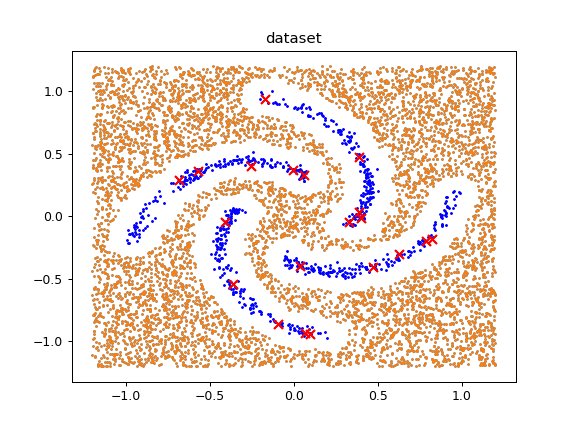

In [52]:
################Choose dataset #################
X,y = spiral(200)
# X,y = datasets.make_moons(n_samples=1000,noise=0.01)
# X = np.concatenate([np.random.multivariate_normal([-1.5,0],np.eye(2)/10,1000),np.random.multivariate_normal([+1.5,0],np.eye(2)/10,1000)])
# y = np.concatenate([np.ones(1000),np.zeros(1000)])
nb_labels = 5
################################################
ids = np.random.permutation(y.shape[0])
X=X[ids]
y=y[ids]
txs=[]
tys=[]
for j in range(int(np.max(y))+1):
    txs.append(X[y==j][:nb_labels])
    tys.append(y[y==j][:nb_labels])
X_lab = np.concatenate(txs,axis=0)
y_lab = np.concatenate(tys,axis=0)
f,ax = plt.subplots()
scatter_dataset(ax,X,np.zeros_like(y),s=1,c='b')
scatter_dataset(ax,X_lab,y_lab,s=50,marker='x',c='r')
ax.set_title('dataset')
# return X,y, X_lab, Y_lab
ex = gen_examples(10000,X)
scatter_dataset(ax,ex,np.zeros(ex.shape[0]),s=1)

<IPython.core.display.Javascript object>


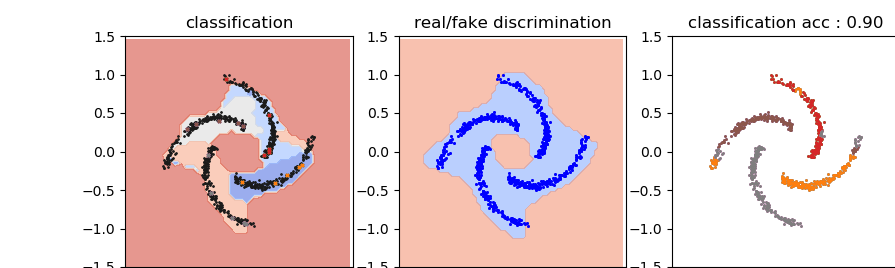

epoch 0 | loss d = 2.9712 | loss g = 0.0000 | train acc = 55.00 | test acc = 47.00 
epoch 1 | loss d = 2.9338 | loss g = 0.0000 | train acc = 65.00 | test acc = 61.37 
epoch 2 | loss d = 2.8999 | loss g = 0.0000 | train acc = 75.00 | test acc = 67.87 
epoch 3 | loss d = 2.8649 | loss g = 0.0000 | train acc = 75.00 | test acc = 69.37 
epoch 4 | loss d = 2.8302 | loss g = 0.0000 | train acc = 75.00 | test acc = 74.25 
epoch 5 | loss d = 2.7926 | loss g = 0.0000 | train acc = 70.00 | test acc = 73.50 
epoch 6 | loss d = 2.7548 | loss g = 0.0000 | train acc = 70.00 | test acc = 74.50 
epoch 7 | loss d = 2.7182 | loss g = 0.0000 | train acc = 70.00 | test acc = 76.25 
epoch 8 | loss d = 2.6811 | loss g = 0.0000 | train acc = 70.00 | test acc = 76.25 
epoch 9 | loss d = 2.6452 | loss g = 0.0000 | train acc = 70.00 | test acc = 76.62 
epoch 10 | loss d = 2.6096 | loss g = 0.0000 | train acc = 70.00 | test acc = 76.37 
epoch 11 | loss d = 2.5756 | loss g = 0.0000 | train acc = 65.00 | test acc

epoch 96 | loss d = 1.7509 | loss g = 0.0000 | train acc = 100.00 | test acc = 98.25 
epoch 97 | loss d = 1.7423 | loss g = 0.0000 | train acc = 100.00 | test acc = 98.25 
epoch 98 | loss d = 1.7452 | loss g = 0.0000 | train acc = 100.00 | test acc = 98.37 
epoch 99 | loss d = 1.7391 | loss g = 0.0000 | train acc = 100.00 | test acc = 98.62 
epoch 100 | loss d = 1.7405 | loss g = 0.0000 | train acc = 100.00 | test acc = 98.75 
epoch 101 | loss d = 1.7426 | loss g = 0.0000 | train acc = 100.00 | test acc = 98.75 
epoch 102 | loss d = 1.7378 | loss g = 0.0000 | train acc = 100.00 | test acc = 98.75 
epoch 103 | loss d = 1.7285 | loss g = 0.0000 | train acc = 100.00 | test acc = 98.75 
epoch 104 | loss d = 1.7324 | loss g = 0.0000 | train acc = 100.00 | test acc = 98.75 
epoch 105 | loss d = 1.7283 | loss g = 0.0000 | train acc = 100.00 | test acc = 99.00 
epoch 106 | loss d = 1.7193 | loss g = 0.0000 | train acc = 100.00 | test acc = 99.00 
epoch 107 | loss d = 1.7210 | loss g = 0.0000 |

epoch 191 | loss d = 1.4788 | loss g = 0.0000 | train acc = 100.00 | test acc = 95.50 
epoch 192 | loss d = 1.4742 | loss g = 0.0000 | train acc = 100.00 | test acc = 95.50 
epoch 193 | loss d = 1.4799 | loss g = 0.0000 | train acc = 100.00 | test acc = 95.50 
epoch 194 | loss d = 1.4630 | loss g = 0.0000 | train acc = 100.00 | test acc = 95.50 
epoch 195 | loss d = 1.4716 | loss g = 0.0000 | train acc = 100.00 | test acc = 95.50 
epoch 196 | loss d = 1.4604 | loss g = 0.0000 | train acc = 100.00 | test acc = 95.50 
epoch 197 | loss d = 1.4581 | loss g = 0.0000 | train acc = 100.00 | test acc = 95.50 
epoch 198 | loss d = 1.4638 | loss g = 0.0000 | train acc = 100.00 | test acc = 95.50 
epoch 199 | loss d = 1.4610 | loss g = 0.0000 | train acc = 100.00 | test acc = 95.50 
epoch 200 | loss d = 1.4566 | loss g = 0.0000 | train acc = 100.00 | test acc = 95.50 
epoch 201 | loss d = 1.4559 | loss g = 0.0000 | train acc = 100.00 | test acc = 95.50 
epoch 202 | loss d = 1.4442 | loss g = 0.00

epoch 286 | loss d = 1.2894 | loss g = 0.0000 | train acc = 100.00 | test acc = 94.25 
epoch 287 | loss d = 1.3192 | loss g = 0.0000 | train acc = 100.00 | test acc = 94.12 
epoch 288 | loss d = 1.2961 | loss g = 0.0000 | train acc = 100.00 | test acc = 93.62 
epoch 289 | loss d = 1.3075 | loss g = 0.0000 | train acc = 100.00 | test acc = 93.75 
epoch 290 | loss d = 1.3036 | loss g = 0.0000 | train acc = 100.00 | test acc = 94.25 
epoch 291 | loss d = 1.3042 | loss g = 0.0000 | train acc = 100.00 | test acc = 94.00 
epoch 292 | loss d = 1.2990 | loss g = 0.0000 | train acc = 100.00 | test acc = 94.00 
epoch 293 | loss d = 1.3034 | loss g = 0.0000 | train acc = 100.00 | test acc = 93.62 
epoch 294 | loss d = 1.3030 | loss g = 0.0000 | train acc = 100.00 | test acc = 94.25 
epoch 295 | loss d = 1.2962 | loss g = 0.0000 | train acc = 100.00 | test acc = 93.50 
epoch 296 | loss d = 1.3063 | loss g = 0.0000 | train acc = 100.00 | test acc = 93.00 
epoch 297 | loss d = 1.2875 | loss g = 0.00

KeyboardInterrupt: 

In [53]:
tf.reset_default_graph()
# sess = tf.InteractiveSession()
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
ssgan = Model(sess, nb_epoch=1000, lr_g=0.03, lr_d=0.001, print_frequency=1,nb_class=4,batch_size=400)

f, ax = plt.subplots(1,3, sharex=True)
f.set_size_inches(10,3)
f.subplots_adjust(hspace=0.5)
plt.ion()
f.show()
f.canvas.draw()

ssgan.train(f,ax,X,X_lab,y_lab,X,y)
f.close()

In [ ]:


xmin=-3
xmax=3
ymin=-3
ymax=3

X_gen = ssgan.generate_random_samples(100)
plt.close()
f, ax = plt.subplots(1,3, sharey=True)
f.set_size_inches(10,5)

X0, X1 = X_train[:, 0], X_train[:, 1]
xx, yy = make_meshgrid(X0, X1,xmin,xmax,ymin,ymax)
plot_contours(ax[0], ssgan.predict, xx,yy,cmap=plt.cm.coolwarm, alpha=0.6)
ax[0].scatter(X_train[:,0] ,X_train[:,1], s=1)
ax[0].scatter(X_train_lab[y_train_lab==0][:,0],X_train_lab[y_train_lab==0][:,1],s=50)
ax[0].scatter(X_train_lab[y_train_lab==1][:,0],X_train_lab[y_train_lab==1][:,1],s=50)
ax[0].scatter(X_gen[:,0],X_gen[:,1],c='r',s=5)
ax[0].set_title('classification')
ax[0].set_xlim(xmin,xmax)
ax[0].set_ylim(ymin,ymax)

X_gen = ssgan.generate_random_samples(100)
X0, X1 = X_train[:, 0], X_train[:, 1]
plot_contours(ax[1], ssgan.discriminate, xx,yy,cmap=plt.cm.coolwarm, alpha=0.6)
ax[1].scatter(X_train[:,0] ,X_train[:,1], s=1)
ax[1].scatter(X_train_lab[y_train_lab==0][:,0],X_train_lab[y_train_lab==0][:,1],s=25)
ax[1].scatter(X_train_lab[y_train_lab==1][:,0],X_train_lab[y_train_lab==1][:,1],s=25)
ax[1].scatter(X_gen[:,0],X_gen[:,1],c='r',s=5)
ax[1].set_title('discrimination')
ax[1].set_xlim(xmin,xmax)
ax[1].set_ylim(ymin,ymax)

pred = ssgan.predict(X_train)
scatter_dataset(ax[2],X_train,pred,s=5)
ax[2].scatter(X_train_lab[y_train_lab==0][:,0],X_train_lab[y_train_lab==0][:,1],s=50)
ax[2].scatter(X_train_lab[y_train_lab==1][:,0],X_train_lab[y_train_lab==1][:,1],s=50)
ax[2].set_title('classification')
ax[2].set_xlim(xmin,xmax)
ax[2].set_ylim(ymin,ymax)

plt.show()

In [44]:
X.shape

(800, 2)